In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_mnist_loaders(batch_size=32):
  transform = transforms.ToTensor()
  train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

  test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, test_loader

In [2]:
import matplotlib.pyplot as plt # For plotting and displaying images
def visualize_batch(batch_size=16):
  # Load a mini-batch of training data
  train_loader, _ = get_mnist_loaders(batch_size)
  images, labels = next(iter(train_loader)) # Get the first batch

  # Create a horizontal grid of images
  plt.figure(figsize=(10, 4))
  for i in range(batch_size):
    plt.subplot(2, batch_size // 2, i + 1) # 2 rows, batch_size/2 columns
    plt.imshow(images[i][0], cmap='gray') # Show the image (channel 0 since MNIST is grayscale)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

100%|██████████| 9.91M/9.91M [00:11<00:00, 891kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.02MB/s]


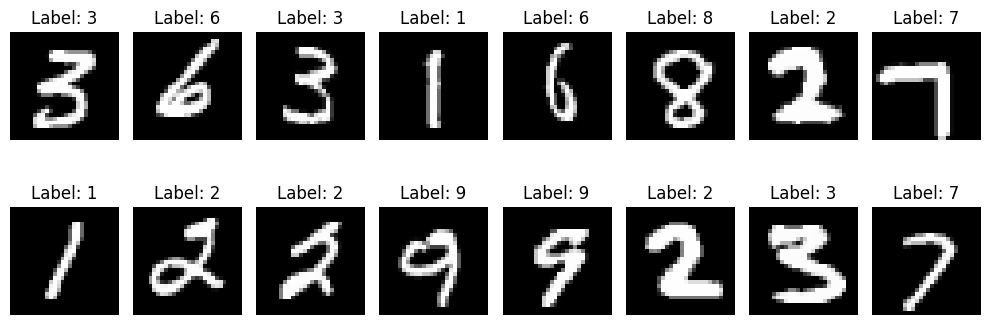

In [3]:
visualize_batch()

In [4]:
train_loader, test_loader = get_mnist_loaders(32)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size) -> None:
    super().__init__()

    self.x_t = nn.Linear(input_size, hidden_size) # A data point in our case, an image pixel
    self.c_t = nn.Linear(hidden_size, hidden_size) # The memory cell (more like the activation since in GRUs a_t = c_t)

    self.x_t_r = nn.Linear(input_size, hidden_size) # Relevance matrix
    self.c_t_r = nn.Linear(hidden_size, hidden_size) # Relevance matrix

    self.x_t_u = nn.Linear(input_size, hidden_size) # Update matrix
    self.c_t_u = nn.Linear(hidden_size, hidden_size) # Update matrix
  def forward(self, x, c_t_prev):

    gamma_u = F.sigmoid(self.c_t_u(c_t_prev) + self.x_t_u(x)) # Update gate

    gamma_r = F.sigmoid(self.c_t_r(c_t_prev) + self.x_t_r(x)) # Relevance gate

    c_t_tilde = F.tanh(self.c_t(gamma_r * c_t_prev) + self.x_t(x)) # output

    c_t = gamma_u * c_t_tilde + (1 - gamma_u) * c_t_prev

    return c_t


In [7]:
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, GRUCell=GRUCell) -> None:
    super().__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.GRUCell = GRUCell(input_size, hidden_size)

  def forward(self, x):
    # using batch first [batch_size, seq_len, input_size]
    output = []
    batch_size, seq_len, _ = x.shape
    c_t = torch.zeros(batch_size, self.hidden_size).to(x.device) # c_t for one data point or pixel

    for i in range(seq_len): # iterating through each pixel

      c_t = self.GRUCell(x[:, i, :], c_t)

      output.append(c_t)

    return torch.stack(output), c_t


In [8]:
class DigitClassification(nn.Module):
  def __init__(self, input_size=28, hidden_size=128, output_size=10) -> None:
    super().__init__()

    self.gru = GRU(input_size, hidden_size)
    self.classifier = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = x.view(x.shape[0], 28, 28)
    output, c_t = self.gru(x)
    out = self.classifier(c_t)
    return out

In [9]:
criterion = nn.CrossEntropyLoss()
model = DigitClassification()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs=10
for epoch in range(epochs):
  running_loss = 0.0
  for image, target in train_loader:
    image = image.to(device)
    target = target.to(device)

    optimizer.zero_grad()

    output = model.forward(image)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print(f"Epoch: {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch: 1, Loss: 0.3821188646500309
Epoch: 2, Loss: 0.09624521113932133
Epoch: 3, Loss: 0.06622859690232823
Epoch: 4, Loss: 0.05134889295408502
Epoch: 5, Loss: 0.04086330350704181
Epoch: 6, Loss: 0.034850305111209554
Epoch: 7, Loss: 0.029862093949092863
Epoch: 8, Loss: 0.024089865983087416
Epoch: 9, Loss: 0.02408636848607954
Epoch: 10, Loss: 0.020219191493724552


In [13]:
# Test the accuracy of the model
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, target in test_loader:
    images = images.to(device)
    target = target.to(device)

    output = model.forward(images)

    _, topk = output.topk(1, dim=1)

    topk = topk.squeeze(1)

    correct += (topk == target).sum()

    total += target.size(0)

  print(f"Accuracy: {100*correct/total}%")

Accuracy: 98.75%


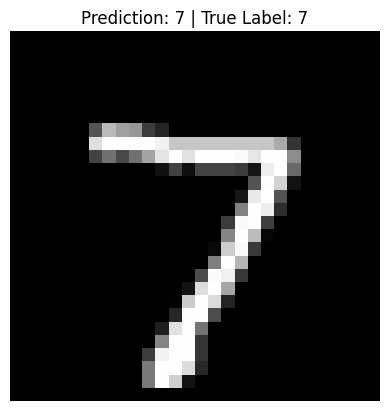

In [19]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Set model to eval mode
model.eval()

# Get one batch from test_loader
images, labels = next(iter(test_loader))

# Pick one sample
index = 0
image = images[index].to(device).unsqueeze(0)  # Add batch dimension
label = labels[index]

# Make prediction
with torch.no_grad():
    output = model(image)
    _, pred = output.topk(1, dim=1)
    pred = pred.item()

# Show image
plt.imshow(TF.to_pil_image(images[index]), cmap="gray")
plt.title(f"Prediction: {pred} | True Label: {label.item()}")
plt.axis('off')
plt.show()

In [1]:
!jupyter nbconvert --to markdown --output=GRU GRU.ipynb

[NbConvertApp] Converting notebook GRU.ipynb to markdown
[NbConvertApp] Support files will be in GRU_files/
[NbConvertApp] Making directory GRU_files
[NbConvertApp] Writing 5982 bytes to GRU.md
